In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
from scipy import stats
import seaborn as sns


before_rmse_f: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/evalutaed/before/c_rmse/rmse.csv')
after_rmse_f: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/evalutaed/after/c_rmse/rmse.csv')

In [2]:
df: pl.DataFrame = (pl.concat([pl.scan_csv(f)
                                 .unique(subset=['lab', 'sample', 'feature', 'fgroup'],
                                         keep='first')
                                 .with_columns(pl.lit(n).alias('treatment'))
                               for f, n in zip([before_rmse_f, after_rmse_f],
                                               ['before', 'after'])])
                      .collect())
df

lab,sample,feature,fgroup,count,rmse,treatment
str,str,str,str,i64,f64,str
"""BS2""","""D6_1""","""compact_depth_bin:compact_beta…","""4x:0–10""",21249,9.059217,"""before"""
"""BS4""","""D6_1""","""compact_depth_bin""","""1x""",4693137,38.454945,"""before"""
"""PS3""","""BL_2""","""compact_depth_bin:compact_beta…","""1x:40–50""",1273,49.925892,"""before"""
"""PS3""","""T4_1""","""compact_depth_bin:compact_beta…","""4x:40–50""",568,25.843081,"""before"""
"""PS1""","""T4_2""","""compact_depth_bin:compact_beta…","""3x:0–10""",1181,9.099363,"""before"""
…,…,…,…,…,…,…
"""RR1""","""T1_1""","""compact_depth_bin:compact_beta…","""1x:60–70""",44848,18.753874,"""after"""
"""EM2""","""BC_1""","""compact_depth_bin:compact_beta…","""3x:0–10""",22374,8.325608,"""after"""
"""EM3""","""BC_1""","""compact_depth_bin:compact_beta…","""4x:90–100""",278,19.997658,"""after"""


In [3]:
df_pivot: pl.DataFrame = (df.pivot(on='treatment',
                                   index=['lab', 'sample', 'feature', 'fgroup'],
                                   values='rmse')
                            .with_columns((pl.col('before') - pl.col('after')).alias('diff'))
                            .drop_nulls())
df_pivot

lab,sample,feature,fgroup,before,after,diff
str,str,str,str,f64,f64,f64
"""BS2""","""D6_1""","""compact_depth_bin:compact_beta…","""4x:0–10""",9.059217,7.426199,1.633018
"""BS4""","""D6_1""","""compact_depth_bin""","""1x""",38.454945,22.855277,15.599668
"""PS3""","""BL_2""","""compact_depth_bin:compact_beta…","""1x:40–50""",49.925892,30.192344,19.733548
"""PS3""","""T4_1""","""compact_depth_bin:compact_beta…","""4x:40–50""",25.843081,16.018602,9.824479
"""PS1""","""T4_2""","""compact_depth_bin:compact_beta…","""3x:0–10""",9.099363,7.277765,1.821597
…,…,…,…,…,…,…
"""PS3""","""T2_2""","""compact_depth_bin:compact_beta…","""2x:0–10""",13.813791,12.723446,1.090345
"""EM3""","""T4_2""","""compact_depth_bin:compact_beta…","""3x:40–50""",29.645331,18.621201,11.02413
"""BS1""","""T1_1""","""compact_depth_bin:compact_beta…","""1x:70–80""",32.351409,19.390135,12.961274


In [4]:
from typing import Literal


def run_paired_test(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05,
                    return_item: Literal['test_type', 'p_val', 'diff'] = 'p_val'):
    diff: pl.Series = (before - after).alias('diff')

    # Normality Test
    shapiro_stat, shapiro_p = stats.shapiro(diff)

    print(f'Shapiro-Wilk Normality Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}')
    if shapiro_p > 0.05:
        print('✅ Normality Test passed. t test can be used.')
        t_stat, p_val = stats.ttest_rel(after, before)
        print(f'\n👉 t test result:')
        print(f'  t = {t_stat:.3f}, samples = {diff.shape[0]}, p = {p_val:.3e}')
        print(f'  average diff = {diff.mean():.3f}')
        result_type = 't_test'
        avg_diff = diff.mean()
    else:
        print('❌ Normality Test failed. Wilcoxon test will be used.')
        w_stat, p_val = stats.wilcoxon(before, after)
        print(f'\n👉 Wilcoxon test result:')
        print(f'  W = {w_stat:.0f}, p = {p_val:.3e}')
        print(f'  median diff = {diff.median():.3f}')
        result_type = 'wilcoxon'
        avg_diff = diff.median()

    if p_val < alpha:
        print('✅ There is a significant difference between before and after treatment (p < 0.05)')
    else:
        print('❌ There is no significant difference between before and after treatment (p ≥ 0.05)')

    # significant: bool = True if p_val < alpha else False
    if return_item == 'test_type':
        return result_type
    elif return_item == 'p_val':
        return p_val
    else:
        return avg_diff


def get_result_type(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='test_type')


def get_p_val(before: pl.Series,
               after: pl.Series,
               alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='p_val')


def get_diff(before: pl.Series,
             after: pl.Series,
             alpha: float = .05):
    return run_paired_test(before, after, alpha, return_item='diff')

In [7]:
test_result1: pl.DataFrame = (df_pivot.group_by('feature', 'fgroup')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_p_val(x.struct.field('before'),
                                                                              x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('p_value'))
                                      .with_columns(pl.col('p_value').list.first().alias('p_value'))
                                      .with_columns(pl.when(pl.col('p_value') < 0.05)
                                                      .then(pl.lit(True))
                                                      .otherwise(pl.lit(False))
                                                      .alias('significant')))
test_result2: pl.DataFrame = (df_pivot.group_by('feature', 'fgroup')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff'))
                                      .with_columns(pl.col('diff').list.first().alias('diff')))
test_result3: pl.DataFrame = (df_pivot.group_by('feature', 'fgroup')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_result_type(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.String)
                                             .alias('test_type'))
                                      .with_columns(pl.col('test_type').list.first().alias('test_type')))

test_result: pl.DataFrame = (test_result1.join(other=test_result2,
                                               on=['feature', 'fgroup'],
                                               how='left')
                                         .join(other=test_result3,
                                               on=['feature', 'fgroup'],
                                               how='left')
                                         .select('feature', 'fgroup', 'diff', 'test_type',
                                                 'p_value', 'significant')
                                         .rename({'feature': 'Feature', 'fgroup': 'Value',
                                                  'diff': 'Average Diff',
                                                  'test_type': 'Test Type',
                                                  'p_value': 'P value',
                                                  'significant': 'Significant'}))

Shapiro-Wilk Normality Test: W=0.757, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.766, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.951, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.712, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.656, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.807, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.975, p=0.001
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.878, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.
Shapiro-Wilk Normality Test: W=0.991, p=0.209
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = -69.742, samples = 220, p = 1.584e-151
  average diff = 10.569
✅ There is a significant diffe

In [8]:
test_result

Feature,Value,Average Diff,Test Type,P value,Significant
str,str,f64,str,f64,bool
"""compact_depth_bin:compact_beta…","""1x:0–10""",5.821994,"""wilcoxon""",7.5784e-38,true
"""compact_depth_bin:compact_beta…","""5–10x:60–70""",10.695189,"""wilcoxon""",7.5784e-38,true
"""compact_depth_bin""",""">10x""",9.045764,"""wilcoxon""",7.5784e-38,true
"""compact_depth_bin""","""4x""",9.201864,"""wilcoxon""",7.5784e-38,true
"""compact_depth_bin:compact_beta…",""">10x:30–40""",5.137574,"""wilcoxon""",7.5784e-38,true
…,…,…,…,…,…
"""compact_beta_bin""","""60–70""",10.632515,"""wilcoxon""",7.5784e-38,true
"""compact_beta_bin""","""80–90""",7.442287,"""wilcoxon""",7.5784e-38,true
"""compact_depth_bin:compact_beta…","""1x:20–30""",15.55321,"""wilcoxon""",7.5784e-38,true


In [10]:
test_result.write_csv(
    '/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/6_methcali/rmse_feature_test_result.csv'
)

In [25]:
test_result['feature'].unique().sort().to_list()

['compact_beta_bin', 'compact_depth_bin']

In [33]:
test_result.filter(pl.col('diff') == test_result['diff'].max())

feature,fgroup,p_value,significant,diff,test_type
str,str,f64,bool,f64,str
"""compact_depth_bin:compact_beta…","""1x:40–50""",7.5784e-38,true,27.756494,"""wilcoxon"""


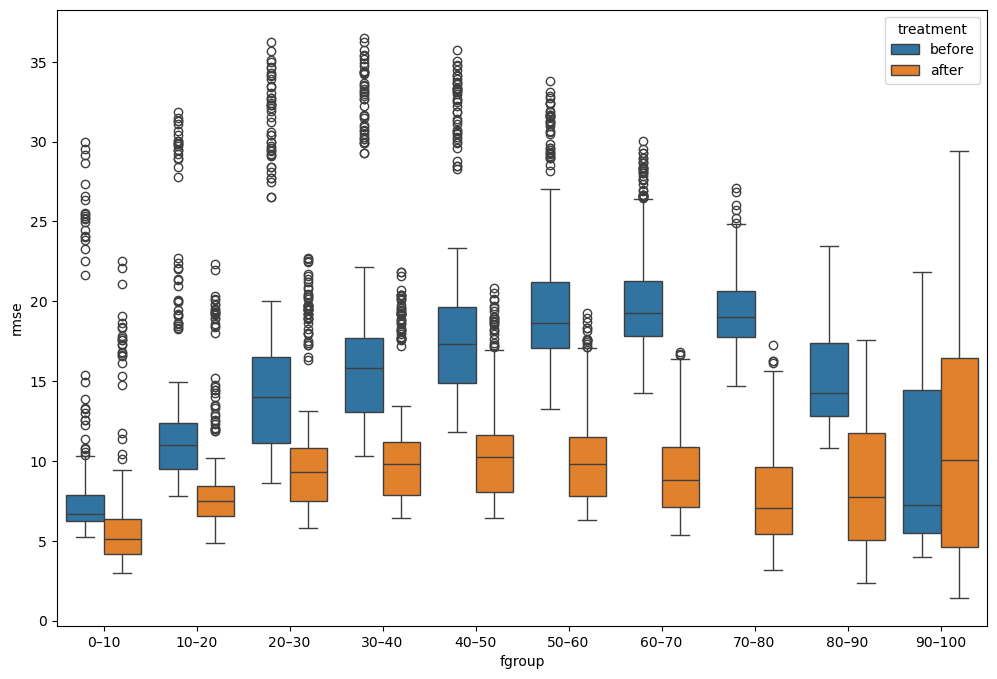

In [69]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure


pdf = df.filter(pl.col('feature') == 'compact_beta_bin').to_pandas()
pdf['fgroup'] = pd.Categorical(pdf['fgroup'],
                               categories=['0–10', '10–20', '20–30', '30–40', '40–50',
                                           '50–60', '60–70', '70–80', '80–90', '90–100'],
                               ordered=True)
fig: Figure = plt.figure(figsize=(12, 8))

ax: Axes = (sns.boxplot(data=pdf,
                        x='fgroup', y='rmse', hue='treatment'))

In [70]:
df.filter(pl.col('feature') == 'compact_depth_bin')['fgroup'].unique().sort().to_list()

['1x', '2x', '3x', '4x', '5–10x', '>10x']

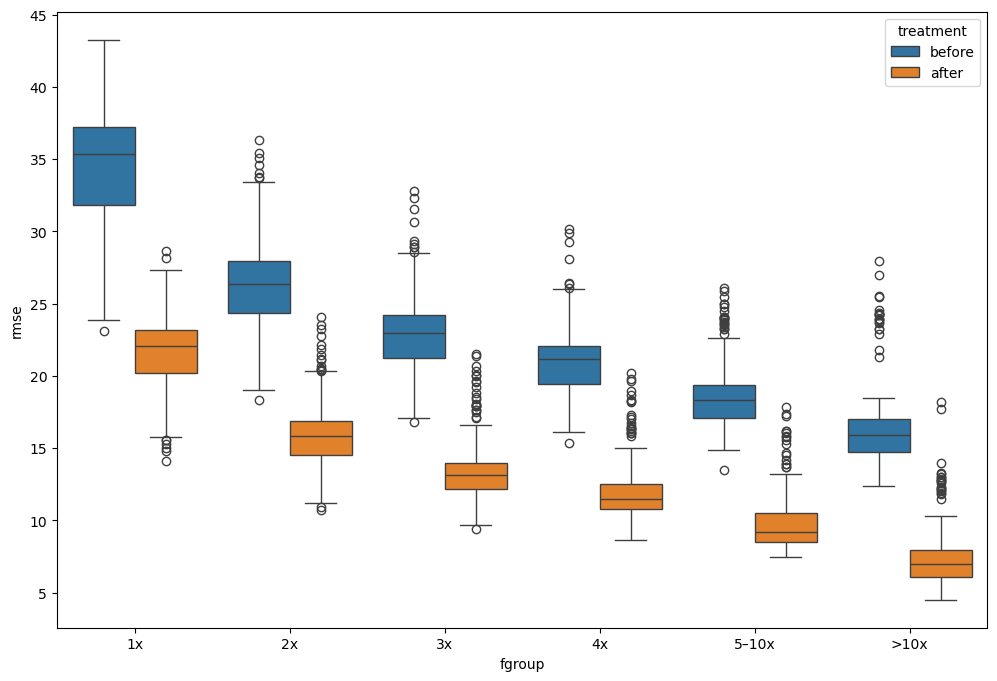

In [71]:
pdf = df.filter(pl.col('feature') == 'compact_depth_bin').to_pandas()
pdf['fgroup'] = pd.Categorical(pdf['fgroup'],
                               categories=['1x', '2x', '3x', '4x', '5–10x', '>10x'],
                               ordered=True)

fig: Figure = plt.figure(figsize=(12, 8))

ax: Axes = (sns.boxplot(data=pdf,
                        x='fgroup', y='rmse', hue='treatment'))

<Axes: xlabel='label', ylabel='rmse'>

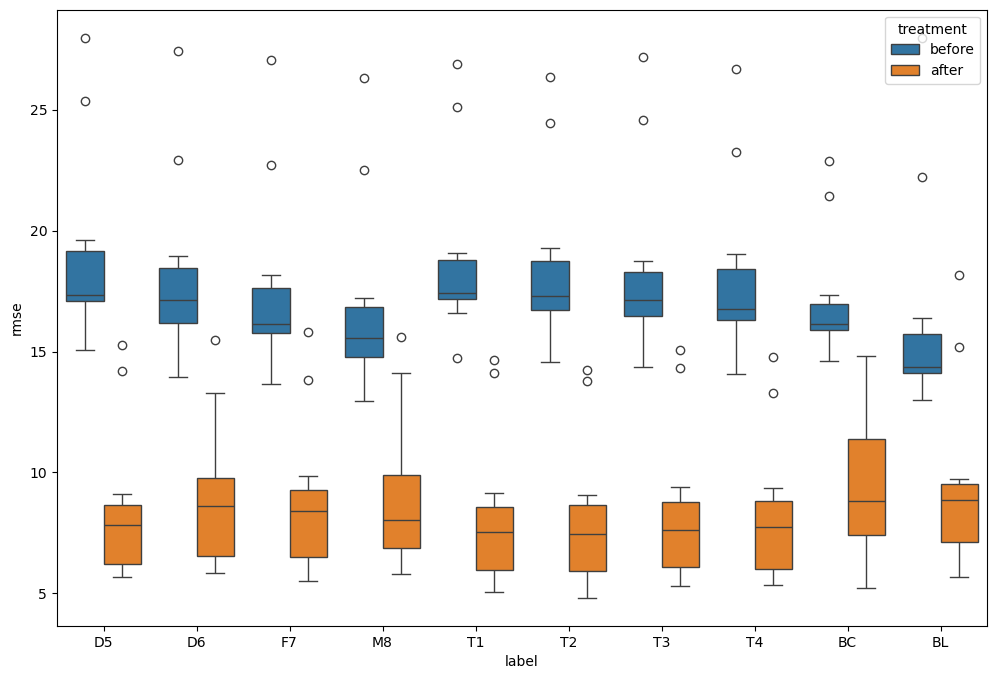

In [38]:
sample_average: pl.DataFrame
sample_average = (df.filter(pl.col('feature') == 'global')
                    .with_columns(pl.col('sample').str.head(2).alias('label'))
                    .group_by('lab', 'label', 'treatment')
                    .agg(pl.col('rmse').mean().alias('rmse')))
fig = plt.figure(figsize=(12, 8))

(sns.boxplot(data=sample_average.to_pandas(),
             x='label', y='rmse', hue='treatment', hue_order=['before', 'after'],
             order=['D5', 'D6', 'F7', 'M8', 'T1', 'T2', 'T3', 'T4', 'BC', 'BL']))


In [42]:
sample_pivot: pl.DataFrame
sample_pivot = (sample_average.pivot(on='treatment', index=['lab', 'label'], values='rmse')
                              .with_columns((pl.col('before') - pl.col('after')).alias('diff')))

In [47]:
sample_test_result1: pl.DataFrame = (sample_pivot.group_by('label')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_p_val(x.struct.field('before'),
                                                                              x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('p_value'))
                                      .with_columns(pl.col('p_value').list.first().alias('p_value'))
                                      .with_columns(pl.when(pl.col('p_value') < 0.05)
                                                      .then(pl.lit(True))
                                                      .otherwise(pl.lit(False))
                                                      .alias('significant')))
sample_test_result2: pl.DataFrame = (sample_pivot.group_by('label')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_diff(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.Float64)
                                             .alias('diff'))
                                      .with_columns(pl.col('diff').list.first().alias('diff')))
sample_test_result3: pl.DataFrame = (sample_pivot.group_by('label')
                                      .agg(pl.struct(['before', 'after'])
                                             .map_batches(lambda x: get_result_type(x.struct.field('before'),
                                                                             x.struct.field('after')),
                                                          return_dtype=pl.String)
                                             .alias('test_type'))
                                      .with_columns(pl.col('test_type').list.first().alias('test_type')))

sample_test_result: pl.DataFrame = (sample_test_result1.join(other=sample_test_result2,
                                               on=['label'],
                                               how='left')
                                         .join(other=sample_test_result3,
                                               on=['label'],
                                               how='left')
                                         .sort('label'))

Shapiro-Wilk Normality Test: W=0.931, p=0.418
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = -23.611, samples = 11, p = 4.212e-10
  average diff = 10.058
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.949, p=0.629
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = -16.937, samples = 11, p = 1.083e-08
  average diff = 7.828
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.894, p=0.157
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = -25.067, samples = 11, p = 2.337e-10
  average diff = 10.407
✅ There is a significant difference between before and after treatment (p < 0.05)
Shapiro-Wilk Normality Test: W=0.934, p=0.450
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = -10.320, samples = 11, p = 1.191e-06
  average diff = 7.522
✅ There is a significant difference between before a

In [48]:
sample_test_result

label,p_value,significant,diff,test_type
str,f64,bool,f64,str
"""BC""",0.000001,true,9.061008,"""t_test"""
"""BL""",5.1886e-8,true,5.121885,"""t_test"""
"""D5""",3.7263e-10,true,11.05404,"""t_test"""
"""D6""",1.0977e-9,true,9.973254,"""t_test"""
"""F7""",3.3233e-9,true,7.173137,"""t_test"""
"""M8""",1.0826e-8,true,5.421012,"""t_test"""
"""T1""",2.4549e-10,true,12.237106,"""t_test"""
"""T2""",2.3368e-10,true,8.214073,"""t_test"""
"""T3""",4.2125e-10,true,10.932933,"""t_test"""


In [49]:
(sample_average.pivot(on='treatment', index=['lab', 'label'], values='rmse')
               .with_columns((pl.col('before') - pl.col('after')).alias('diff'))
               .with_columns((100 * pl.col('diff') / pl.col('before')).alias('diff_pct'))
               .group_by('label')
               .agg(pl.col('diff').mean().alias('mean_diff'),
                    pl.col('diff_pct').mean().alias('mean_diff_pct'))
               .sort('label'))

label,mean_diff,mean_diff_pct
str,f64,f64
"""BC""",7.521835,44.15826
"""BL""",6.929312,43.497478
"""D5""",10.553378,56.29914
"""D6""",9.288951,51.868882
"""F7""",8.858732,51.136602
"""M8""",7.8285,47.170563
"""T1""",10.626544,57.347317
"""T2""",10.407088,57.027903
"""T3""",10.057943,55.659303
